In [8]:
import pandas as pd
import numpy as np
import os
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix, classification_report
import seaborn as sns
import matplotlib.pyplot as plt

Leemos los datos completos que hemos extraído usando el pipeline en esta fase final.

In [9]:
ruta_df =  os.path.join("..","..","..", "data", "processed","df_dif.parquet")
df = pd.read_parquet(ruta_df)
df

,DATE,Peleador_A,Peleador_B,WINNER,KD_DIFF,SIG_STR_DIFF,TD_DIFF,SUB_ATT_DIFF,REV_DIFF,CTRL_DIFF,...,Record_DIFF,Peleas_DIFF,Puntos_DIFF,Racha_DIFF,Victorias_KO_DIFF,Victorias_Sub_DIFF,Victorias_Decision_DIFF,Derrotas_KO_DIFF,Derrotas_Sub_DIFF,Derrotas_Decision_DIFF
0,2000-06-09,Kevin Randleman,Pedro Rizzo,False,-0.60,-0.0768,0.650000,0.72,0.00,378.72,...,-3.0,0,-3.993707,-2,-0.96,0.00,0.36,0.00,0.00,0.60
1,2000-09-22,Jeremy Horn,Eugene Jackson,False,-0.64,0.1836,0.315789,0.80,0.00,-2.24,...,73.0,0,10.209519,3,-1.00,1.36,0.00,0.00,-0.36,0.00
2,2001-02-23,Tito Ortiz,Evan Tanner,False,0.24,-0.2368,0.221893,-1.12,0.00,600.96,...,-17.0,2,1.291944,-1,1.04,-0.64,0.60,1.00,0.00,0.00
3,2001-05-04,Chuck Liddell,Kevin Randleman,False,0.00,0.0552,-0.508475,-1.64,0.40,-601.12,...,1.0,-2,4.775221,2,0.60,0.00,-2.24,-0.36,1.00,-1.00
4,2001-06-29,Pat Miletich,Shonie Carter,False,-0.72,-0.0608,0.022094,0.88,-1.12,-122.28,...,-33.0,2,-10.170940,-3,0.64,1.60,-0.60,0.00,0.36,0.00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3515,2025-04-05,Manuel Torres,Drew Dober,False,0.00,0.1544,0.242133,0.24,0.00,-20.40,...,-3.0,-20,83.951757,0,-7.00,-0.40,-3.00,-1.00,-4.00,-3.60
3516,2025-04-12,Loma Lookboonmee,Istela Nunes,False,-0.24,0.1976,0.549550,0.24,0.40,193.24,...,3.0,4,136.714077,3,0.00,0.60,4.36,-0.96,-1.00,1.00
3517,2025-04-12,Pat Sabatini,Joanderson Brito,False,0.00,0.2212,-0.048376,-0.36,0.00,-25.60,...,-1.0,1,-192.148931,1,-2.60,0.36,3.00,1.60,0.00,-1.36
3518,2025-04-12,Josh Emmett,Lerone Murphy,True,-0.04,-0.2400,-0.365385,-0.80,0.00,-236.68,...,2.0,6,-176.360781,-7,1.36,0.00,1.04,1.00,1.00,1.60


Separamos los datos "nuevos" extraídos de los "antiguos".

In [10]:
df["DATE"] = pd.to_datetime(df["DATE"])

# Filtra los combates después del 16 de febrero de 2025
df_antiguos = df[df["DATE"] <= "2025-02-16"]
df_antiguos = df_antiguos[df_antiguos["DATE"] >= "2010-01-01"]
df_nuevos = df[df["DATE"] > "2025-02-16"]
df_nuevos

,DATE,Peleador_A,Peleador_B,WINNER,KD_DIFF,SIG_STR_DIFF,TD_DIFF,SUB_ATT_DIFF,REV_DIFF,CTRL_DIFF,...,Record_DIFF,Peleas_DIFF,Puntos_DIFF,Racha_DIFF,Victorias_KO_DIFF,Victorias_Sub_DIFF,Victorias_Decision_DIFF,Derrotas_KO_DIFF,Derrotas_Sub_DIFF,Derrotas_Decision_DIFF
3476,2025-02-22,Rodolfo Vieira,Andre Petroski,True,0.00,0.1304,-0.370211,0.60,0.00,-219.68,...,0.0,-2,-4.982062e+01,0,-1.00,1.96,-2.96,-2.00,1.00,1.00
3477,2025-02-22,Julia Avila,Jacqueline Cavalcanti,True,0.00,-0.1032,0.271186,0.24,0.12,68.20,...,-1.0,2,-4.270556e+01,-3,1.00,0.60,-0.96,0.00,0.36,1.00
3478,2025-02-22,Jared Cannonier,Gregory Rodrigues,False,0.00,-0.1840,0.198616,0.00,0.00,-80.80,...,-2.0,9,-8.507418e+01,-3,1.40,0.00,2.64,1.60,0.00,3.36
3479,2025-02-22,Calvin Kattar,Youssef Zalal,True,-0.36,-0.3132,-0.466667,-1.40,0.00,-130.24,...,4.0,3,-1.757769e+02,-3,4.00,-1.96,0.00,0.60,0.00,0.36
3480,2025-02-22,Gabriel Bonfim,Khaos Williams,False,-0.76,-0.0888,0.500000,0.64,0.00,-41.32,...,3.0,-4,-5.453563e+01,-1,-3.36,2.00,-1.24,0.60,0.00,-2.00
3481,2025-02-22,Ismael Bonfim,Nazim Sadykhov,True,0.04,0.1248,-0.240472,-0.24,-0.24,-65.12,...,8.0,0,-1.390264e+02,1,0.00,-0.60,0.36,0.00,0.60,-0.36
3482,2025-02-22,Angela Hill,Ketlen Souza,False,-0.36,-0.2596,0.204702,-0.12,0.40,190.20,...,-8.0,23,5.149431e+01,-2,2.00,0.24,8.40,0.00,1.00,11.36
3483,2025-03-01,Ricky Simon,Javid Basharat,False,0.00,-0.1476,-0.095434,0.00,0.00,-59.80,...,0.0,8,1.665199e+01,0,1.00,3.00,1.00,2.00,0.00,1.60
3484,2025-03-01,Jean Silva,Melsik Baghdasaryan,False,0.88,0.0012,0.285714,0.00,0.00,-13.76,...,4.0,-1,2.150642e+02,2,0.96,0.00,-1.36,0.00,-0.60,0.00
3485,2025-03-01,Henry Cejudo,Song Yadong,True,-0.40,0.0452,0.016316,0.00,0.00,-81.40,...,1.0,0,-5.804300e-01,0,-1.00,-1.00,1.40,0.00,0.00,0.60


Usamos como train el dataset antiguo completo. El test serán los datos nuevos.

In [11]:
X_train = df_antiguos.drop(columns=["WINNER", "DATE","Peleador_A","Peleador_B"])
y_train = df_antiguos["WINNER"]
X_test = df_nuevos.drop(columns=["WINNER", "DATE","Peleador_A","Peleador_B"])
y_test = df_nuevos["WINNER"]

Entrenamos el mejor modelo que obtuvimos en la fase de evaluación anterior.

In [12]:

params = {'n_estimators': 100, 'max_depth': 39, 'learning_rate': 0.013855267540212752, 'subsample': 0.7097002483532678, 'colsample_bytree': 0.9049166524337446, 'gamma': 0.3376761198544125, 'min_child_weight': 13, 'scale_pos_weight': np.float64(1.2905829596412555), 'reg_alpha': 0.5, 'tree_method': 'exact', 'grow_policy': 'lossguide'} 

xgboost_dif = XGBClassifier(**params)

xgboost_dif.fit(X_train, y_train)

y_pred_xgboost_dif = xgboost_dif.predict(X_test)

print("Reporte de clasificación xgboost_dif:")
print(classification_report(y_test, y_pred_xgboost_dif))
print(f'Accuracy: {accuracy_score(y_test, y_pred_xgboost_dif):.4f}')
print(f"F1-score: {f1_score(y_test,y_pred_xgboost_dif)}")

Reporte de clasificación xgboost_dif:
              precision    recall  f1-score   support

       False       0.75      0.58      0.65        26
        True       0.54      0.72      0.62        18

    accuracy                           0.64        44
   macro avg       0.65      0.65      0.64        44
weighted avg       0.66      0.64      0.64        44

Accuracy: 0.6364
F1-score: 0.6190476190476191


Conseguimos una accuracy incluso mejor que en la evaluación anterior, lo que nos indica que el modelo funciona peor con los datos más recientes. 

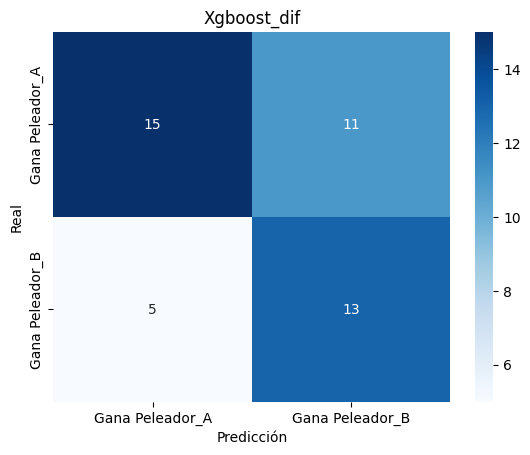

In [13]:
cm = confusion_matrix(y_test, y_pred_xgboost_dif)

# Visualizar la matriz de confusión
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Gana Peleador_A', 'Gana Peleador_B'], yticklabels=['Gana Peleador_A', 'Gana Peleador_B'])
plt.xlabel('Predicción')
plt.ylabel('Real')
plt.title('Xgboost_dif')
plt.show()

Como podemos ver los resultados son similares a los que obtuvimos en la fase de evaluación anterior. Podemos ver que se nota una subida en las victorias del peleador A. Si esto se mantiene o aumenta durante el tiempo habría que estudiar con que espacio temporal merece la pena predecir. Es decir, si esta tendencia aumenta habría que intentar entrenar con peleas más recientes que sigan esta tendencia. Por el momento al ser una muestra pequeña no podemos sacar conclusiones pero debemos ver como se desarrolla esta tendencia en el tiempo.

In [14]:
y_pred_probs = xgboost_dif.predict_proba(X_test)
df_nuevos = df_nuevos.reset_index(drop=True)
# Creamos el DataFrame con los datos
df_resultados = pd.DataFrame({
    'Peleador A': df_nuevos['Peleador_A'].values,
    'Peleador B': df_nuevos['Peleador_B'].values,
    'Ganador': y_test.values,
    'Predicción': y_pred_xgboost_dif,
    'Probabilidad A': y_pred_probs[:, 0],  # Asumiendo clase 1 es A gana
    'Probabilidad B': y_pred_probs[:, 1]   # Asumiendo clase 0 es B gana
})



# Mostrar los primeros resultados
df_resultados

,Peleador A,Peleador B,Ganador,Predicción,Probabilidad A,Probabilidad B
0,Rodolfo Vieira,Andre Petroski,True,0,0.517208,0.482792
1,Julia Avila,Jacqueline Cavalcanti,True,1,0.465637,0.534363
2,Jared Cannonier,Gregory Rodrigues,False,1,0.413646,0.586354
3,Calvin Kattar,Youssef Zalal,True,1,0.370188,0.629812
4,Gabriel Bonfim,Khaos Williams,False,0,0.506073,0.493927
5,Ismael Bonfim,Nazim Sadykhov,True,1,0.388272,0.611728
6,Angela Hill,Ketlen Souza,False,0,0.527485,0.472515
7,Ricky Simon,Javid Basharat,False,1,0.442071,0.557929
8,Jean Silva,Melsik Baghdasaryan,False,0,0.615039,0.384961
9,Henry Cejudo,Song Yadong,True,1,0.430455,0.569545


Mostramos las diferentes peleas que hemos predicho con los porcentajes que le da a cada peleador. Vemos que las predicciones tienden a estar igualadas. Es decir, el modelo pocas veces predice que va a ganar un peleador claramente.

In [15]:
# Crear un DataFrame para las importancias de las características
feature_importance = pd.DataFrame({
    'Feature': X_train.columns,
    'Importance': xgboost_dif.feature_importances_
}).sort_values(by='Importance', ascending=False)
print(feature_importance)

                    Feature  Importance
20               Racha_DIFF    0.071037
19              Puntos_DIFF    0.054177
26   Derrotas_Decision_DIFF    0.045837
18              Peleas_DIFF    0.040622
8                 TD_A_DIFF    0.039168
14        STR_GROUND_A_DIFF    0.038948
5                 CTRL_DIFF    0.037656
24         Derrotas_KO_DIFF    0.037270
4                  REV_DIFF    0.036553
3              SUB_ATT_DIFF    0.036135
7          TOTAL_STR_A_DIFF    0.035594
9           STR_HEAD_A_DIFF    0.035350
11           STR_LEG_A_DIFF    0.035244
2                   TD_DIFF    0.034925
16            GRAPPLER_DIFF    0.034397
12      STR_DISTANCE_A_DIFF    0.034148
15             STRIKER_DIFF    0.034052
25        Derrotas_Sub_DIFF    0.033602
10          STR_BODY_A_DIFF    0.032880
21        Victorias_KO_DIFF    0.032724
1              SIG_STR_DIFF    0.032484
6              TD_PORC_DIFF    0.031937
23  Victorias_Decision_DIFF    0.031859
17              Record_DIFF    0.031588


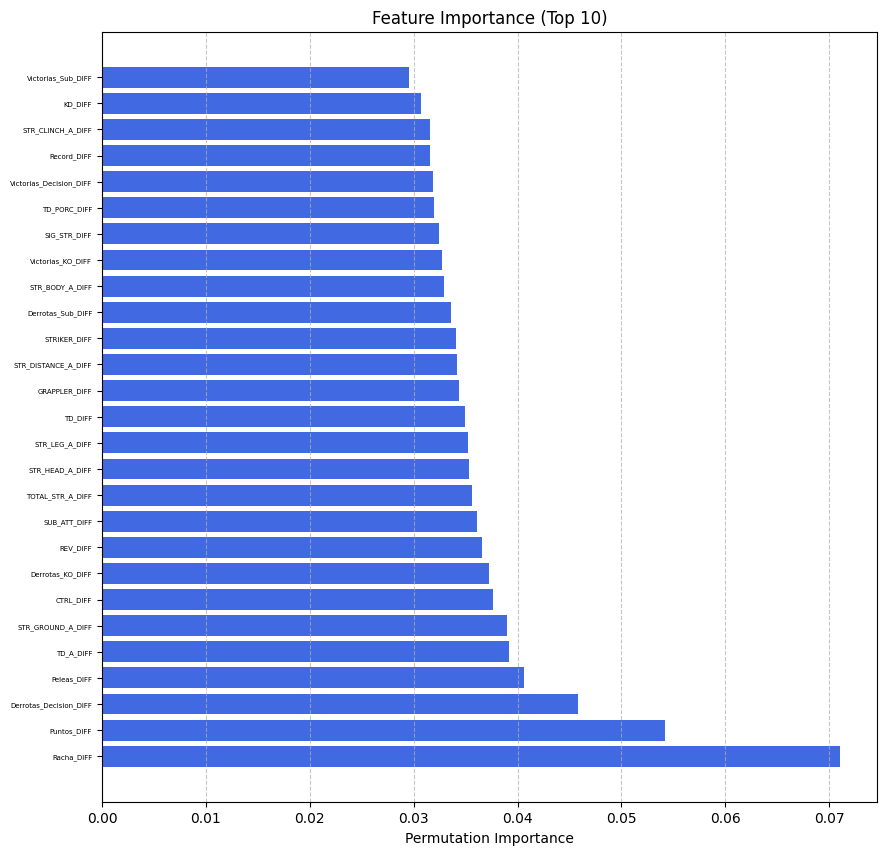

In [16]:
plt.figure(figsize=(10, 10))
plt.barh(feature_importance["Feature"], feature_importance["Importance"], color="royalblue")
plt.xlabel("Permutation Importance")
plt.title("Feature Importance (Top 10)")
plt.yticks(fontsize=5)
plt.grid(axis="x", linestyle="--", alpha=0.7)
plt.show()

La importancia de las variables se mantiene similar a la previamente vista en la fase anterior. Se mantiene la diferencia en la racha y en los puntos como variables más importantes. 

In [24]:
columnas_extra = ["DATE", "Peleador_A", "Peleador_B", "WINNER"]

resultados = X_test.copy()
resultados["WINNER"] = df_nuevos["WINNER"].values
resultados["Predicho"] = y_pred_xgboost_dif
resultados["Correcto"] = resultados["WINNER"] == resultados["Predicho"]
# En el dataframe resultados tengo todas las variables además de dos nuevas, la predicción del ganador y si ha acertado o no


In [26]:
aciertos = resultados[resultados["Correcto"] == True]
fallos = resultados[resultados["Correcto"] == False]

mediasNormales = resultados.drop(columns=[ "WINNER", 'KD_DIFF', 'SIG_STR_DIFF', 'TD_DIFF', 'Victorias_KO_DIFF', 'Victorias_Sub_DIFF']).mean() #elimino ciertas variables que no aportan valor a la gráfica
#print(mediasNormales)
mediasAciertos = aciertos.drop(columns=["WINNER", 'KD_DIFF', 'SIG_STR_DIFF', 'TD_DIFF', 'Victorias_KO_DIFF', 'Victorias_Sub_DIFF']).mean()
#print(mediasAciertos)
mediasFallos = fallos.drop(columns=["WINNER", 'KD_DIFF', 'SIG_STR_DIFF', 'TD_DIFF', 'Victorias_KO_DIFF', 'Victorias_Sub_DIFF']).mean()
#print(mediasFallos)

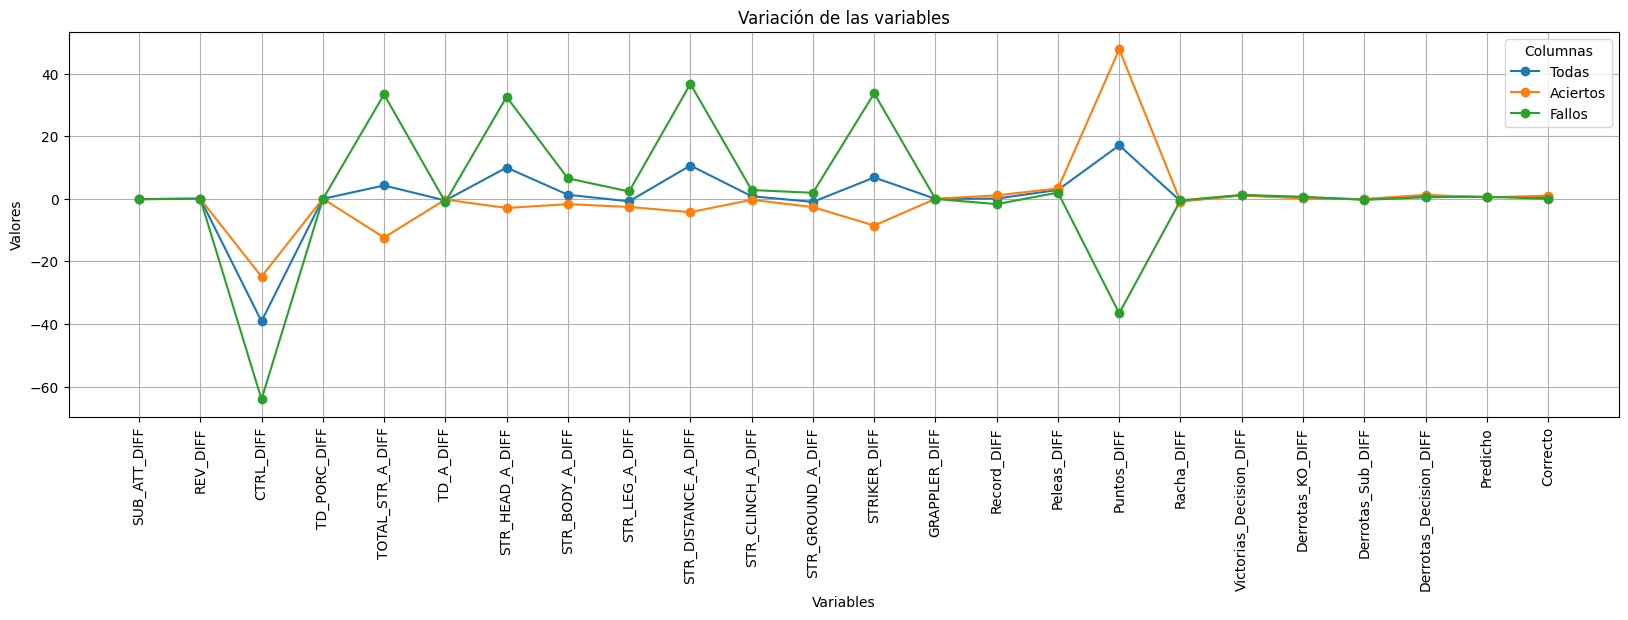

In [27]:
data = {
    'Todas': mediasNormales,
    'Aciertos': mediasAciertos,
    'Fallos': mediasFallos
}
df = pd.DataFrame(data)

plt.figure(figsize=(20, 5))
df.plot(kind='line', marker='o', ax=plt.gca()) 
plt.title('Variación de las variables')
plt.xlabel('Variables')
plt.ylabel('Valores')
plt.legend(title='Columnas')
plt.grid(True)
plt.xticks(ticks=range(len(df.index)), labels=df.index, rotation=90)
plt.show()

En este gráfico se observa la variación de las variables en los casos de aciertos, fallos y en general. Al compararlo con el obtenido en la evaluación anterior, se pueden apreciar algunos cambios. La diferencia de puntos ha disminuido y, en particular, variables como CTRL_DIFF, que en la evaluación anterior se mantenía cercana a cero, tienden ahora a tomar valores negativos.

Es importante tener en cuenta que la muestra de nuevos datos no es muy grande, por lo que estos cambios podrían deberse al azar y no necesariamente reflejar una tendencia real. No obstante, resulta fundamental estudiar el desarrollo estas posibles variaciones, ya que podrían indicar un cambio de comportamiento que nuestro modelo debe ser capaz de captar, evitando así que se base únicamente en patrones del pasado.

In [17]:
X_train = df.drop(columns=["WINNER", "DATE","Peleador_A","Peleador_B"])
y_train = df["WINNER"]

In [18]:
xgboost_dif.fit(X_train,y_train)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=0.9049166524337446, device=None,
              early_stopping_rounds=None, enable_categorical=False,
              eval_metric=None, feature_types=None, gamma=0.3376761198544125,
              grow_policy='lossguide', importance_type=None,
              interaction_constraints=None, learning_rate=0.013855267540212752,
              max_bin=None, max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=39, max_leaves=None,
              min_child_weight=13, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=100, n_jobs=None,
              num_parallel_tree=None, random_state=None, ...)

Reentrenamos el modelo con el dataset completo para pasarlo a producción de la forma más completa posible.

In [22]:
ruta_modelo = os.path.join("..","..","..", "data", "xgboost_P2.xgb")
xgboost_dif.save_model(ruta_modelo)


c:\Users\mattu\OneDrive\Documentos\GitHub\c2425-R4\.venv\Lib\site-packages\xgboost\core.py:158: UserWarning: [10:19:28] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\c_api\c_api.cc:1374: Saving model in the UBJSON format as default.  You can use file extension: `json`, `ubj` or `deprecated` to choose between formats.
  warnings.warn(smsg, UserWarning)


Guardo el modelo final para pasarlo a producción.